# Diffusion equation with spatial dependence

Comparison between [the *py-pde* example](https://py-pde.readthedocs.io/en/latest/examples_gallery/simple_pdes/pde_heterogeneous_diffusion.html) and the reimplementation with PyMPDATA.

## Background
**What is a kymograph?**

A kymograph is a two-dimensional plot of the evolution of a quantity over time and space. It is often used in physics to visualise how a variable changes along a spatial dimension as time progresses. The name is derived from the Greek words *"kyma"* (swell or wave) and *"graph"* (writing), reflecting its use in capturing wave-like phenomena.

## Initial setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging
import time

import numpy as np
import pde as py_pde
from IPython.display import display
from PyMPDATA_examples.comparisons_against_pypde.diffusion_equation_with_spatial_dependence import (
    solutions,
)
from PyMPDATA_examples.comparisons_against_pypde.diffusion_equation_with_spatial_dependence.solutions import (
    SimulationArgs,
)

logging.basicConfig(level=logging.INFO, force=True)

original_simulation_args = SimulationArgs(
    grid_bounds= (-5.0, 5.0),
    grid_points=64,
    initial_value=1.0,
    sim_time=100.0,
    dt=1e-3,
)

## Original example from the *py-pde* library

We use the almost identical code as in the original example from the *py-pde* library, which is available [here](https://py-pde.readthedocs.io/en/latest/examples_gallery/simple_pdes/pde_heterogeneous_diffusion.html).

INFO:pde.tools.numba:Compile `dot_compiled` with parallel=True
INFO:pde.pdes.PDE:Using boundary condition `{'value': 0}` for operator `gradient` in PDE for `c`
INFO:pde.tools.numba:Compile `gradient` with parallel=True
INFO:pde.tools.numba:Compile `set_valid` with parallel=True
INFO:pde.tools.numba:Compile `virtual_point` with parallel=True
INFO:pde.tools.numba:Compile `virtual_point` with parallel=True
INFO:pde.tools.numba:Compile `set_valid_bcs` with parallel=True
INFO:pde.tools.numba:Compile `apply_op_compiled` with parallel=True
INFO:pde.pdes.PDE:Using boundary condition `{'value': 0}` for operator `laplace` in PDE for `c`
INFO:pde.tools.numba:Compile `laplace` with parallel=True
INFO:pde.tools.numba:Compile `set_valid` with parallel=True
INFO:pde.tools.numba:Compile `virtual_point` with parallel=True
INFO:pde.tools.numba:Compile `virtual_point` with parallel=True
INFO:pde.tools.numba:Compile `set_valid_bcs` with parallel=True
INFO:pde.tools.numba:Compile `apply_op_compiled` with p

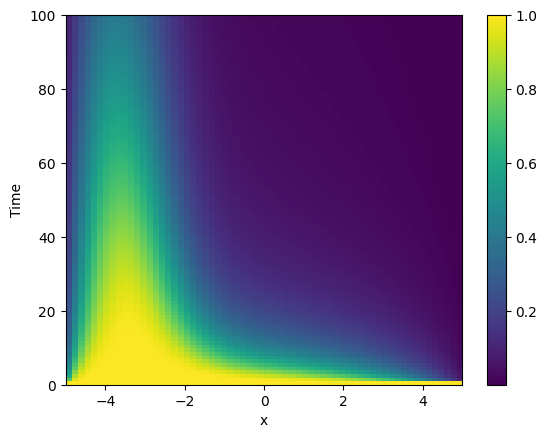

In [24]:
diffusivity = "1.01 + tanh(x)"
term_1 = f"({diffusivity}) * laplace(c)"
term_2 = f"dot(gradient({diffusivity}), gradient(c))"
eq = py_pde.PDE({"c": f"{term_1} + {term_2}"}, bc={"value": 0})

grid = py_pde.CartesianGrid([[-5, 5]], 64)
field = py_pde.ScalarField(grid, 1)

storage = py_pde.MemoryStorage()
res = eq.solve(field, t_range=100, dt=1e-3, tracker=storage.tracker(1))

py_pde.plot_kymograph(storage)

## Our parametrised implementation of the original *py-pde* example

In [3]:
class Timer:
    """A simple timer class to measure elapsed time."""

    def __init__(self):
        self._start = None
        self._time = None

    @property
    def time(self):
        return self._time

    def __enter__(self):
        self._start = time.perf_counter()
        return self

    def __exit__(self, *args):
        self._time = time.perf_counter() - self._start

In [4]:
with Timer() as timer:
    py_pde_result = solutions.py_pde_solution(original_simulation_args)
py_pde_time = timer.time

INFO:pde.tools.numba:Compile `dot_compiled` with parallel=True
INFO:pde.pdes.PDE:Using boundary condition `{'value': 0}` for operator `laplace` in PDE for `c`
INFO:pde.tools.numba:Compile `laplace` with parallel=True
INFO:pde.tools.numba:Compile `set_valid` with parallel=True
INFO:pde.tools.numba:Compile `virtual_point` with parallel=True
INFO:pde.tools.numba:Compile `virtual_point` with parallel=True
INFO:pde.tools.numba:Compile `set_valid_bcs` with parallel=True
INFO:pde.tools.numba:Compile `apply_op_compiled` with parallel=True
INFO:pde.pdes.PDE:Using boundary condition `{'value': 0}` for operator `gradient` in PDE for `c`
INFO:pde.tools.numba:Compile `gradient` with parallel=True
INFO:pde.tools.numba:Compile `set_valid` with parallel=True
INFO:pde.tools.numba:Compile `virtual_point` with parallel=True
INFO:pde.tools.numba:Compile `virtual_point` with parallel=True
INFO:pde.tools.numba:Compile `set_valid_bcs` with parallel=True
INFO:pde.tools.numba:Compile `apply_op_compiled` with p

Verify that the parametrised implementation produces the same results as the original example:

In [7]:
assert np.allclose(
    res.data, py_pde_result.extra["final_result"].data
)

assert np.allclose(
    storage.data, py_pde_result.kymograph_result
)

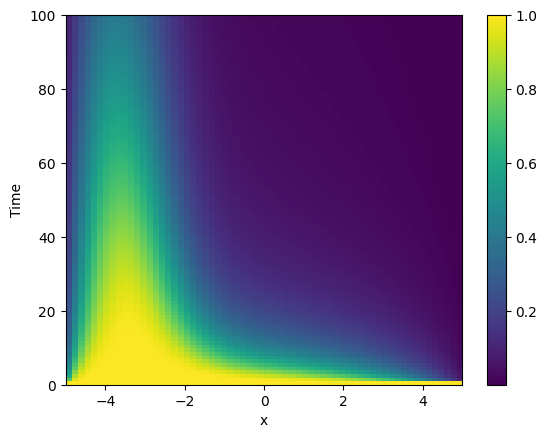

In [5]:
py_pde.plot_kymograph(py_pde_result.extra["storage"])

## Our reimplementation of the example with PyMPDATA

In [6]:
with Timer() as timer:
    pympdata_result = solutions.pympdata_solution(original_simulation_args)
    
pympdata_time = timer.time

INFO:root:Starting heterogeneous diffusion simulation...
INFO:root:Using native PyMPDATA implementation (should be ~3x faster than Strang splitting)
INFO:root:Diffusivity range: 0.010 to 2.010
INFO:root:Using balanced mu coefficient: 0.050000
INFO:root:At step 10000/100000
INFO:root:At step 30000/100000
INFO:root:At step 40000/100000
INFO:root:At step 50000/100000
INFO:root:At step 60000/100000
INFO:root:At step 70000/100000
INFO:root:At step 80000/100000
INFO:root:At step 90000/100000
INFO:root:At step 100000/100000
INFO:root:Simulation completed!
INFO:root:Mass conservation: initial=64.000000, final=4.414727
INFO:root:Relative mass change: 9.31e+01%


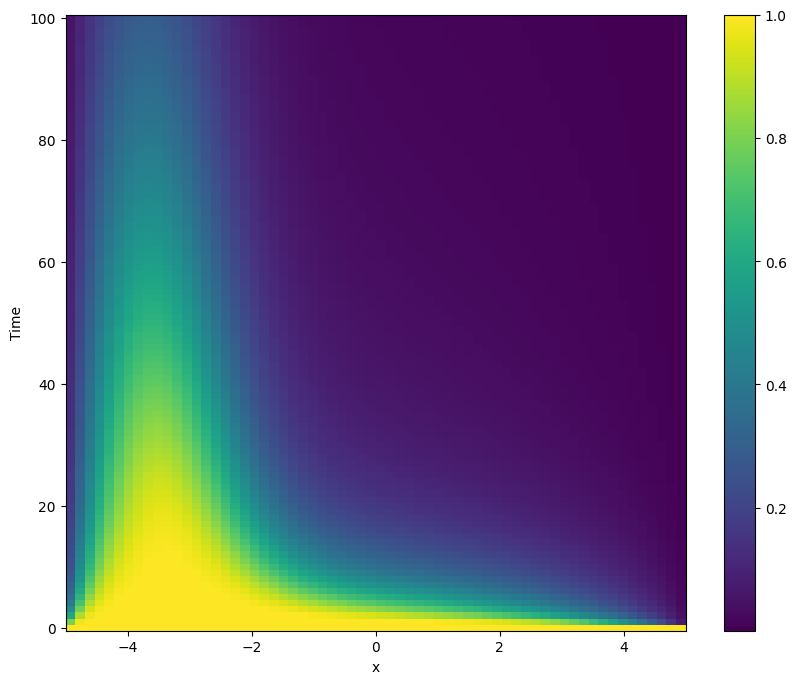

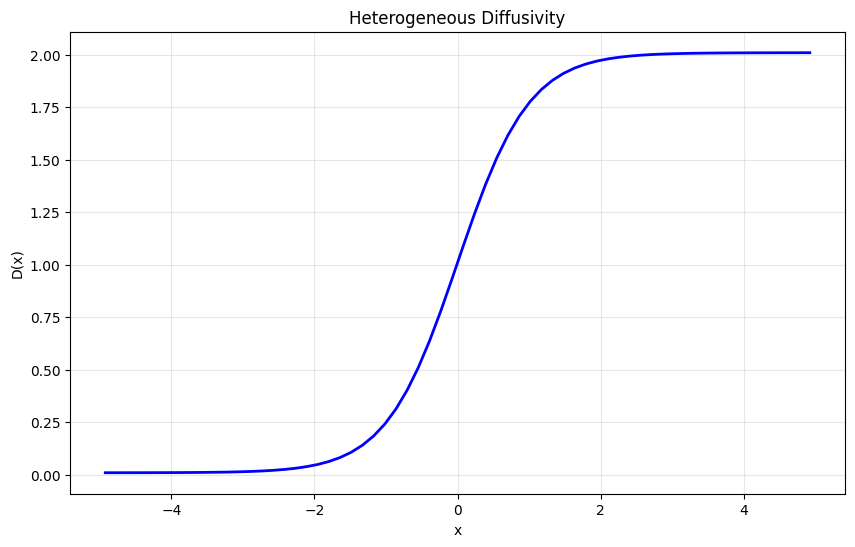

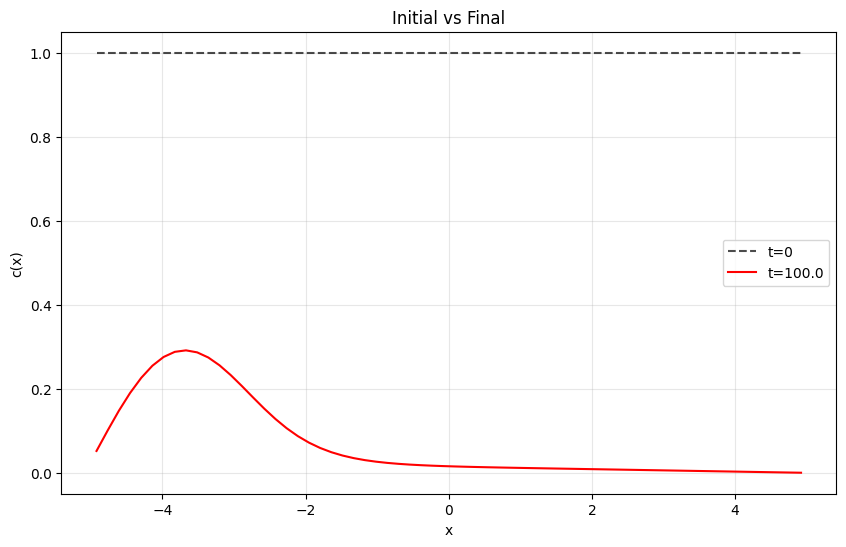

In [10]:
for fig in pympdata_result.figures.values():
    display(fig)

## Comparison

In [11]:
assert (
    py_pde_result.kymograph_result.shape == pympdata_result.kymograph_result.shape
), "Kymograph results do not match in shape."

The calculated absolute difference between the results and Root Mean Square Error (RMSE):

In [12]:
difference = np.abs(pympdata_result.kymograph_result - py_pde_result.kymograph_result)
print("Max difference:", np.max(difference))

rmse = np.sqrt(np.mean(difference**2))
print("RMSE:", rmse)

Max difference: 0.12297365531933913
RMSE: 0.04884992568588479


Similarity comparison:

In [13]:
assert np.allclose(
    pympdata_result.kymograph_result, py_pde_result.kymograph_result, atol=0.2
), "Kymograph results do not match."

Time comparison:

In [14]:
print(f"py-pde time: {py_pde_time:.4f} seconds")
print(f"PyMPDATA time: {pympdata_time:.4f} seconds")

py-pde time: 10.2355 seconds
PyMPDATA time: 746.6280 seconds


## Comparison for a smaller grid and fewer time steps

In [7]:
quicker_simulation_args = SimulationArgs(
    grid_bounds= (-5.0, 0),  # (-0.5, 0.5) -> (-5.0, 0)
    grid_points=32,  # 64 -> 32
    initial_value=1.0,
    sim_time=10.0,  # 100.0 -> 10.0
    dt=1e-3,
)

with Timer() as timer:
    py_pde_quick_result = solutions.py_pde_solution(quicker_simulation_args)
py_pde_quick_time = timer.time

with Timer() as timer:
    pympdata_quick_result = solutions.pympdata_solution(quicker_simulation_args)
pympdata_quick_time = timer.time

print(f"py-pde time: {py_pde_quick_time:.4f} seconds")
print(f"PyMPDATA time: {pympdata_quick_time:.4f} seconds")

INFO:pde.tools.numba:Compile `dot_compiled` with parallel=True
INFO:pde.pdes.PDE:Using boundary condition `{'value': 0}` for operator `laplace` in PDE for `c`
INFO:pde.tools.numba:Compile `laplace` with parallel=True
INFO:pde.tools.numba:Compile `set_valid` with parallel=True
INFO:pde.tools.numba:Compile `virtual_point` with parallel=True
INFO:pde.tools.numba:Compile `virtual_point` with parallel=True
INFO:pde.tools.numba:Compile `set_valid_bcs` with parallel=True
INFO:pde.tools.numba:Compile `apply_op_compiled` with parallel=True
INFO:pde.pdes.PDE:Using boundary condition `{'value': 0}` for operator `gradient` in PDE for `c`
INFO:pde.tools.numba:Compile `gradient` with parallel=True
INFO:pde.tools.numba:Compile `set_valid` with parallel=True
INFO:pde.tools.numba:Compile `virtual_point` with parallel=True
INFO:pde.tools.numba:Compile `virtual_point` with parallel=True
INFO:pde.tools.numba:Compile `set_valid_bcs` with parallel=True
INFO:pde.tools.numba:Compile `apply_op_compiled` with p

py-pde time: 11.9268 seconds
PyMPDATA time: 93.0077 seconds


In [8]:
assert np.allclose(
    pympdata_quick_result.kymograph_result, py_pde_quick_result.kymograph_result, atol=0.2
), "Kymograph results do not match."